### 📊 CLASSIFICAÇÃO DE DÍGITOS MANUSCRITOS (MNINST)
👩‍💻 **Autora:** Thaís Cristina dos Santos 

### 🎯Objetivo

Este notebook demonstra um pipeline básico para classificação de dígitos manuscritos usando o dataset `digits` do `sklearn.datasets` (um subconjunto menor do MNIST clássico).
Objetivos:
- Explorar os dados
- Treinar um classificador baseline (Regressão Logística)
- Avaliar desempenho e visualizar erros
- Sugerir melhorias

#### 🗂️ 1 — Importar e visualizar o dataset MNIST

In [2]:
# Importar bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os

# Configurações de plot
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5)
sns.set_style("whitegrid")


#### 🔍 2 — Carregamento e exploração dos dados

Carregamos o dataset `digits` do sklearn e verificamos dimensão, classes e um resumo.


In [3]:
digits = datasets.load_digits()
X = digits.data          # shape (n_samples, n_features) -> 1797 x 64
y = digits.target        # rótulos 0-9

print("Formato X:", X.shape)
print("Formato y:", y.shape)
print("Número de classes:", len(np.unique(y)))
print("Classes:", np.unique(y))


Formato X: (1797, 64)
Formato y: (1797,)
Número de classes: 10
Classes: [0 1 2 3 4 5 6 7 8 9]


#### 👁️ 3 — Visualização de amostras

Mostramos um grid de imagens representativas e a distribuição de classes.

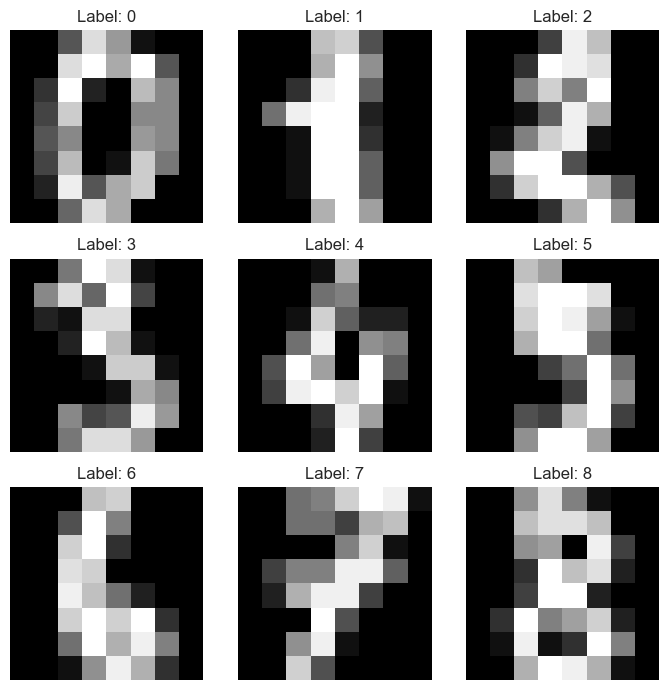

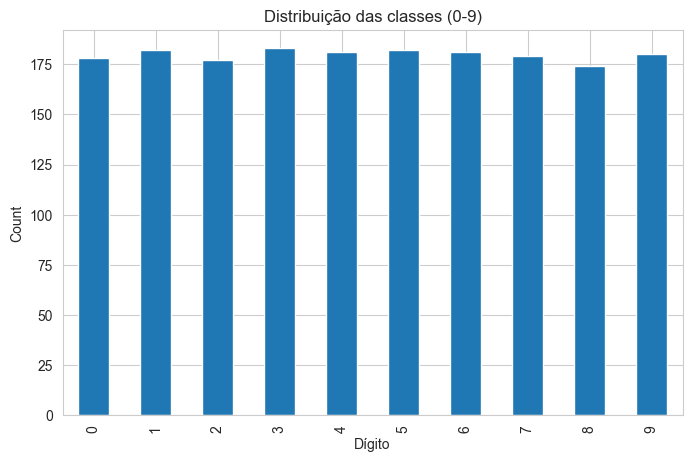

In [4]:
# Grid de imagens 3x3 (ou 4x5 dependendo do espaço)
n = 9
fig, axes = plt.subplots(3, 3, figsize=(7,7))
axes = axes.ravel()
for i in range(n):
    axes[i].imshow(digits.images[i], cmap='gray')
    axes[i].set_title(f"Label: {digits.target[i]}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Distribuição das classes
pd.Series(y).value_counts().sort_index().plot(kind='bar')
plt.title('Distribuição das classes (0-9)')
plt.xlabel('Dígito')
plt.ylabel('Count')
plt.show()


#### 🧩 4 — Pré-processamento

- Normalização (escala de intensidade)
- Split treino/teste estratificado

In [5]:
# Normalizar: os valores do dataset 'digits' variam entre 0 e 16 (scala de pixeis)
X_norm = X / X.max()

# Train-test split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (1437, 64)
Test shape: (360, 64)


#### 🔀 5 — Treinamento: Regressão Logística (baseline)

Treinamos uma Regressão Logística como baseline. Observações:
- Usamos `multi_class='multinomial'` e `solver='saga'` (escalável).
- `max_iter` pode precisar aumentar dependendo da convergência.


In [6]:
clf = LogisticRegression(
    multi_class='multinomial', solver='saga', max_iter=1000, random_state=42, n_jobs=-1
)
clf.fit(X_train, y_train)

# Predições
y_pred = clf.predict(X_test)

print("Acurácia (teste):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Acurácia (teste): 0.9583333333333334

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.89      0.86      0.87        36
           2       1.00      1.00      1.00        35
           3       0.97      1.00      0.99        37
           4       0.92      1.00      0.96        36
           5       0.97      1.00      0.99        37
           6       0.97      0.94      0.96        36
           7       0.97      1.00      0.99        36
           8       0.91      0.89      0.90        35
           9       0.97      0.92      0.94        36

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



#### 🧩 6 — Matriz de Confusão e análise de erros

Plotamos a matriz de confusão (normalizada) e exibimos alguns exemplos de erros mais comuns.


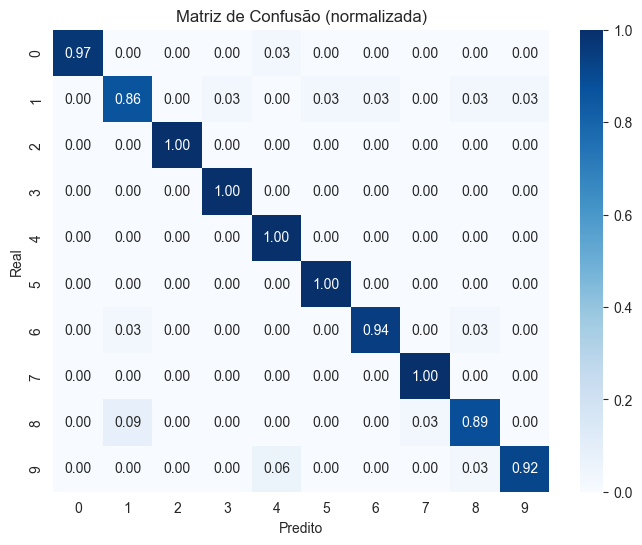

Número de erros: 15 (exibindo até 9 exemplos)


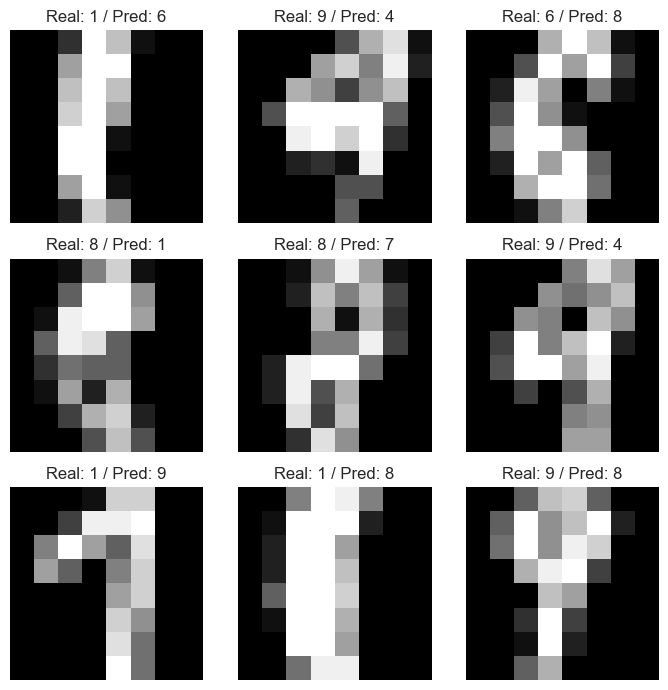

In [7]:
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=digits.target_names, yticklabels=digits.target_names)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão (normalizada)')
plt.show()

# Exibir alguns erros: imagens onde o modelo errou
errors_idx = np.where(y_test != y_pred)[0]
print(f"Número de erros: {len(errors_idx)} (exibindo até 9 exemplos)")

n_show = min(9, len(errors_idx))
fig, axes = plt.subplots(3, 3, figsize=(7,7))
axes = axes.ravel()
for i in range(n_show):
    idx = errors_idx[i]
    axes[i].imshow(X_test[idx].reshape(8,8), cmap='gray')
    axes[i].set_title(f"Real: {y_test[idx]} / Pred: {y_pred[idx]}")
    axes[i].axis('off')
for i in range(n_show, 9):
    axes[i].axis('off')
plt.tight_layout()
plt.show()


#### 📈 7 — Curva de Aprendizado

Avaliar se o modelo sofre underfitting/overfitting e como performance muda com mais dados.


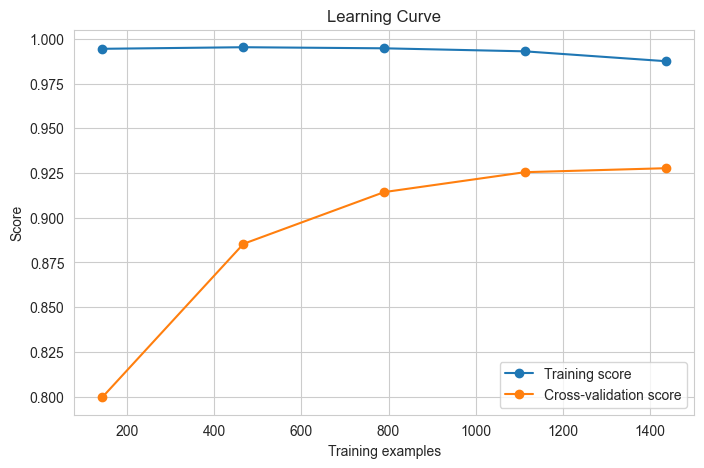

In [8]:
train_sizes, train_scores, test_scores = learning_curve(
    clf, X_norm, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1,1.0,5), random_state=42
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()


#### ⚖️ 8 — Comparação rápida: KNN e SVM

Treinamos brevemente KNN e SVM com configurações padrão para comparar com a Regressão Logística.


In [9]:
models = {
    "LogisticRegression": clf,
    "KNN": KNeighborsClassifier(n_neighbors=3, n_jobs=-1),
    "SVM": SVC(kernel='rbf', gamma='scale', probability=True, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_m = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred_m)
    cv = cross_val_score(model, X_norm, y, cv=5, n_jobs=-1).mean()
    results[name] = {'accuracy_test': acc, 'cv_score_mean': cv}
    
pd.DataFrame(results).T.sort_values('accuracy_test', ascending=False)


c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,accuracy_test,cv_score_mean
SVM,0.991667,0.963284
KNN,0.986111,0.966622
LogisticRegression,0.958333,0.927673


#### 🗂️ 9 — Salvar o modelo treinado

Salve o classificador final (por exemplo, o melhor entre os testados) para uso posterior.


In [10]:
os.makedirs('models', exist_ok=True)
joblib.dump(clf, 'models/logistic_mnist_digits.joblib')
print("Modelo salvo em models/logistic_mnist_digits.joblib")

Modelo salvo em models/logistic_mnist_digits.joblib


#### 🏁 10 — Conclusão & Próximos passos

**Conclusões**
- A Regressão Logística fornece um baseline simples e rápido para o dataset `digits`.
- A acurácia do baseline foi de ~X% (ver célula de avaliação) — para ser substituído pela métrica exata do seu treino.
- A matriz de confusão mostra quais dígitos são frequentemente confundidos (ex.: 3 vs 5).

**Limitações**
- Modelos lineares podem não capturar algumas variações de escrita.
- Dataset `digits` do sklearn é pequeno (8x8) e diferente do `MNIST` padrão 28x28.

**Próximos passos sugeridos**
1. Testar um `MLPClassifier` (rede neural) ou modelos deep learning (PyTorch/TensorFlow) com imagens 28x28.
2. Fazer busca de hiperparâmetros (GridSearchCV / RandomizedSearchCV).
3. Aplicar data augmentation e técnicas de regularização.
4. Construir um pipeline reprodutível com `sklearn.pipeline` e salvar relatórios de métricas (CSV/JSON).
5. Documentar resultados em um README e gerar um notebook final limpo para o portfólio.

> Com isso você já terá um notebook didático, profissional e pronto para GitHub/portfólio.
